In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")

In [46]:
print len(storage.sampleset)

3003


In [47]:
retis = storage.transition.load(0)

In [48]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.005, 'bin_range' : (-0.35, 0.35) }

In [49]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 51.1 s, sys: 3.8 s, total: 54.9 s
Wall time: 55.7 s


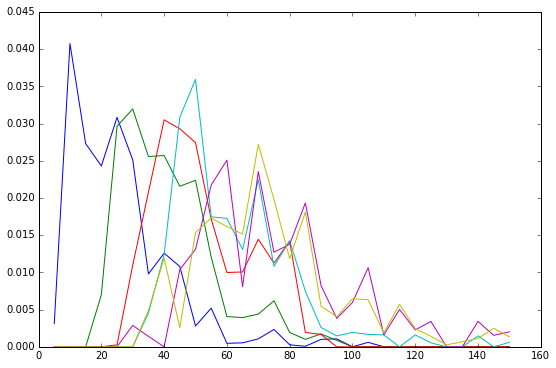

In [50]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

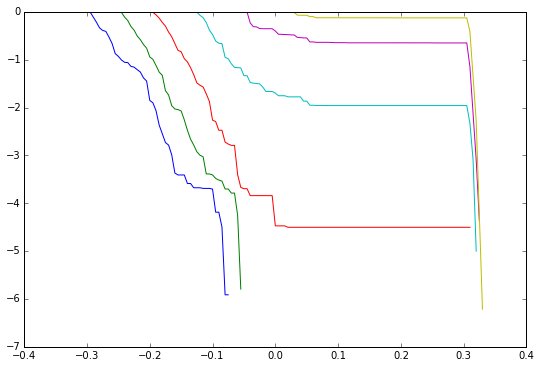

In [51]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

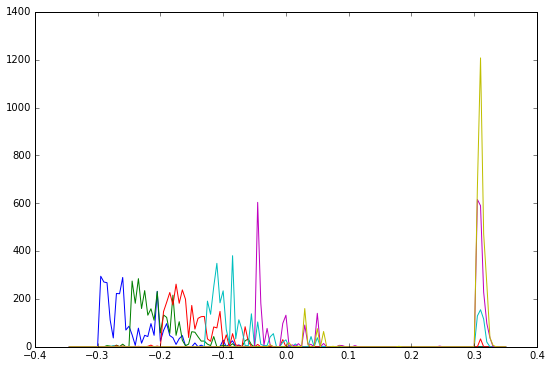

In [52]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

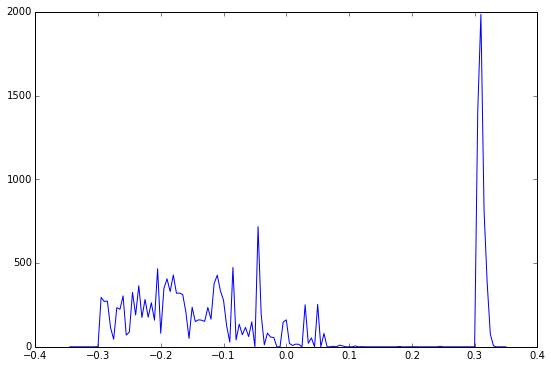

In [53]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling)

In [54]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engine.load(0).pes)

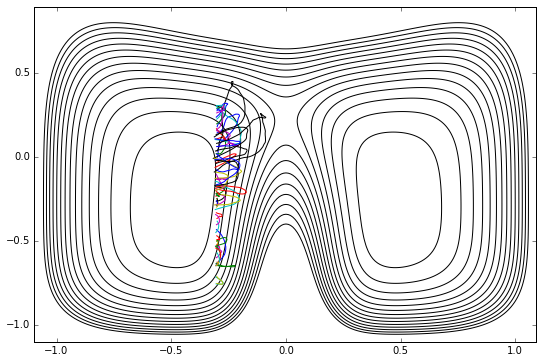

In [55]:
ens0_traj = [s.trajectory for s in storage.sample if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,10)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [56]:
wham_hist = retis.total_crossing_probability()

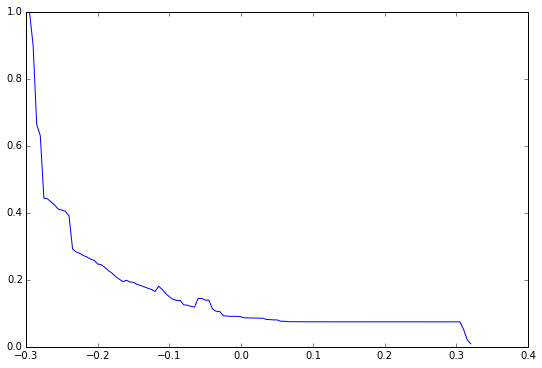

In [57]:
# TODO: conveniences to make this prettier: perhaps actually make wham_hist into a histogram object
wham_hist_list = [ (k, wham_hist[k]) for k in sorted(wham_hist.keys()) ]
plt.plot(list(zip(*wham_hist_list)[0]), list(zip(*wham_hist_list)[1]))

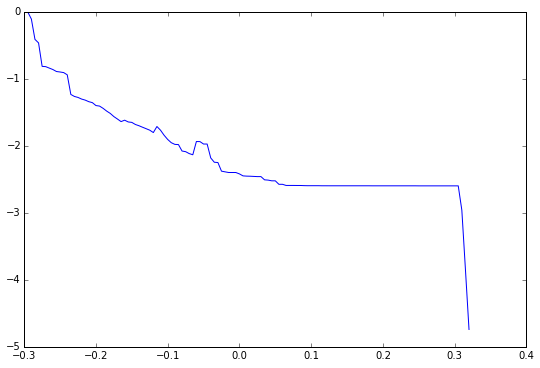

In [58]:
plt.plot(list(zip(*wham_hist_list)[0]), np.log(list(zip(*wham_hist_list)[1])))